## This code trains an encoder/decoder for 1 channel of the pnnl datasets.

Make sure the channel is set:

channel = 1,2 = velocity_y, volume_frac


## Imports

In [ ]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from surrogates4sims.pnnlDatasets import CCSI_2D

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, convertSimToImage, pkl_save, pkl_load, \
                                    create_1_channel_movie, computeSpatialandTimePOD, rel_err, reconFrame

from surrogates4sims.models import Generator, Encoder, AE_no_P, AE_xhat_z, AE_xhat_zV2

from surrogates4sims.train import trainEpoch, validEpoch

import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from glob import glob

## Settings

In [ ]:
svdOutFile = '/data/ccsi/pnnl_liquid_inlet' 
DEBUG = False
# model name, for tensorboard recording and checkpointing purposes.
versionName = "pnnl_plateau_train"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "1"
versionName = versionName + '_GPUs{}'.format(gpu_ids.replace(',',''))
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 1000

# Data Directory
channel = 1
gridsize = 128
svdOutFile = os.path.join(svdOutFile, 'channel_{}'.format(channel))
svdOutFile = svdOutFile + '/svd_channel{}_gridsize{}.pkl'.format(channel,gridsize)
dataDirec = '/data/ccsi/pnnl_liquid_inlet/channel_{}/gridsize_{}'.format(channel,gridsize)
preprocess = False # keep this as false until using the long runtime loader
testSplit = .2
AE = True
numWorkers = 2

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = True  

# hyper-params
seed = 1234
np.random.seed(seed)
bz = 16
numSamplesToKeep = np.infty #if not debugging
latentDim = 16
filters = 128
num_conv = 4 # breaks when less than 2
simLen = 500
stack = True
doJacobian = False
createStreamFcn = False
repeat = 0
skip_connection = False
patience = 2
if DEBUG:
    epochs = 2
    numSamplesToKeep = 2
    
svdOutFile

'/data/ccsi/pnnl_liquid_inlet/channel_1/svd_channel1_gridsize128.pkl'

## Datasets & Loaders

In [ ]:
sims = glob(os.path.join(dataDirec,'*.pkl'))
numSims = len(sims)
idx = int(testSplit*numSims)
testInds = np.linspace(1,numSims-2,idx).astype('int')
trainInds = list(set(np.arange(0,numSims)).difference(set(testInds)))
# perm = np.random.permutation(numSims)
# testInds = perm[:idx]
# trainInds = perm[idx:]
testSimFiles = [sims[idx] for idx in testInds]
trainSimFiles = [sims[idx] for idx in trainInds]
len(testSimFiles), len(trainSimFiles)

(10, 40)

In [ ]:
legend = []
for i in range(numSims):
    if i in testInds:
        legend.append('test_{}'.format(i))
    else:
        legend.append(str(i))
print(legend)

['0', 'test_1', '2', '3', '4', '5', 'test_6', '7', '8', '9', '10', 'test_11', '12', '13', '14', '15', 'test_16', '17', '18', '19', '20', 'test_21', '22', '23', '24', '25', '26', 'test_27', '28', '29', '30', '31', 'test_32', '33', '34', '35', '36', 'test_37', '38', '39', '40', '41', 'test_42', '43', '44', '45', '46', '47', 'test_48', '49']


In [ ]:
dataset = CCSI_2D(sims,doPreprocess=preprocess,numToKeep=numSamplesToKeep,channel=channel,AE=AE)
len(dataset)

25000

In [ ]:
dl = DataLoader(dataset=dataset, batch_size=len(dataset), num_workers=numWorkers)

In [ ]:
X,_ = next(iter(dl))
X.shape

torch.Size([25000, 1, 128, 128])

In [ ]:
if os.path.exists(svdOutFile):
    print('loading file...')
    D = pkl_load(svdOutFile)
    spatialVecs = D['spatialVecs']
    S = D['S']
    timeVecs_transpose = D['timeVecs_transpose']
else:
    spatialVecs, S, timeVecs_transpose = computeSpatialandTimePOD(X,simLen,doPlot=True)
    D = {'spatialVecs':spatialVecs,'S':S,'timeVecs_transpose':timeVecs_transpose}
    pkl_save(D,svdOutFile)
    spatialVecs.shape, S.shape, timeVecs_transpose.shape

loading file...


In [ ]:
Ssum = S**2/np.sum(S**2)
Scumsum = np.sqrt(np.cumsum(Ssum))

In [ ]:
np.cumsum(np.arange(10))

array([ 0,  1,  3,  6, 10, 15, 21, 28, 36, 45])

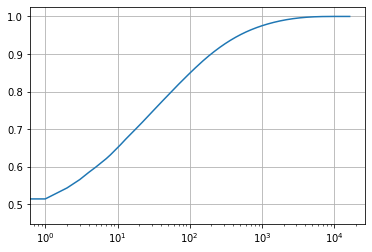

In [ ]:
plt.semilogx(Scumsum)
plt.grid()

## SVD Coeffs

In [ ]:
XX = X.reshape(X.shape[0],-1)
XX.shape

torch.Size([25000, 16384])

In [ ]:
numComp = 512
u = spatialVecs[:,:numComp]
u.shape

(16384, 16384)

In [ ]:
coeffs = np.matmul(XX,u)
coeffs.shape

torch.Size([25000, 16384])

In [ ]:
A = []
for i in range(coeffs.shape[0]//simLen):
    A.append(coeffs[i*simLen:(i+1)*simLen])
A = np.stack(A)
coeffs = A
coeffs.shape

(50, 500, 16384)

## Reconstruct sample 0

In [ ]:
coeffs[0].T.shape

(16384, 500)

In [ ]:
B = np.matmul(u,coeffs[0].T).T
B.shape

(500, 16384)

In [ ]:
B = B.reshape(simLen,gridsize,gridsize)
B.shape

(500, 128, 128)

In [ ]:
F = X[0].numpy()
F.shape

(1, 128, 128)

In [ ]:
BB0,cc = reconFrame(u,F,numComp=numComp)
BB0 = BB0.squeeze()
BB0.shape, cc.shape

((128, 128), (16384,))

In [ ]:
np.max(np.abs(B[0]-BB0))

8.039891360445139e-07

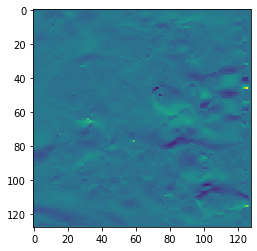

In [ ]:
plt.imshow(BB0.squeeze())
plt.show()

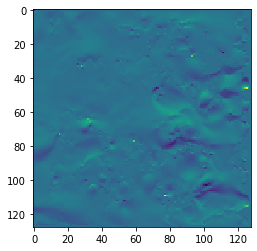

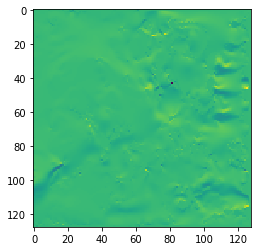

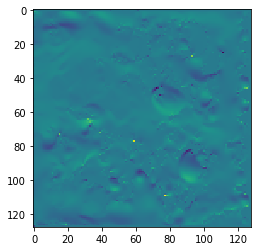

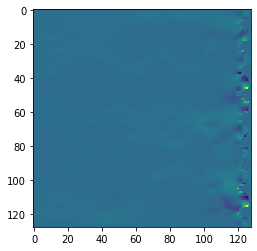

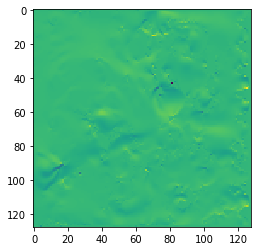

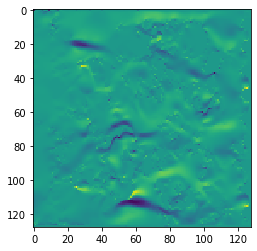

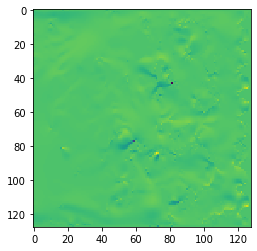

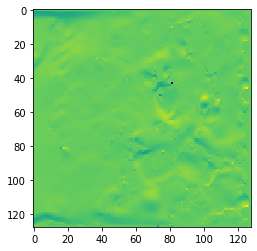

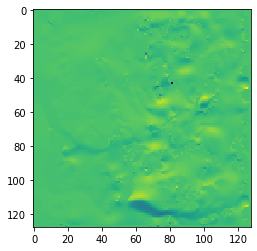

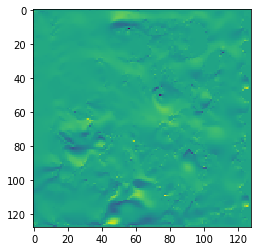

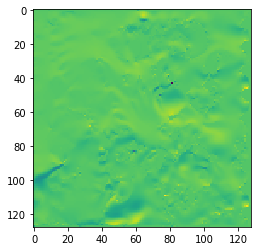

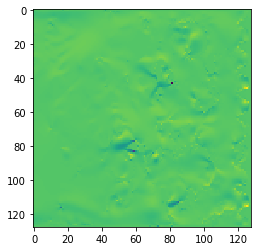

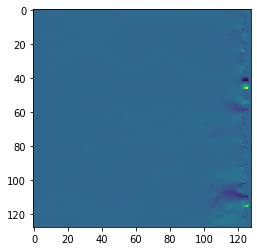

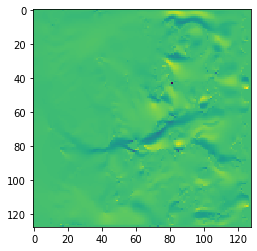

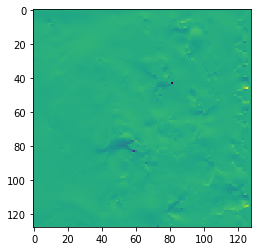

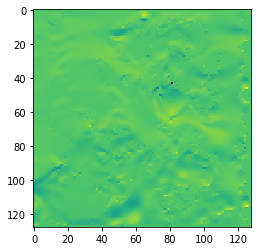

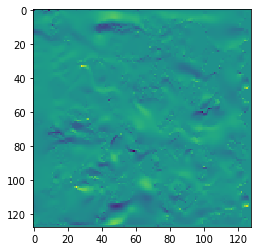

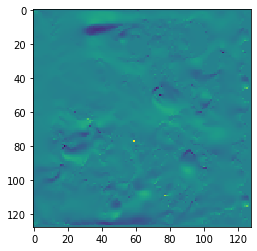

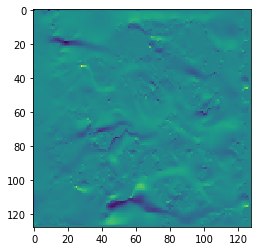

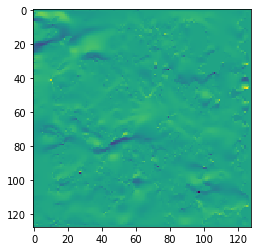

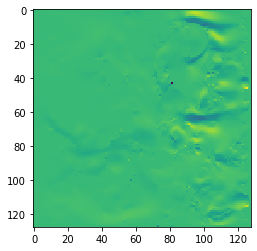

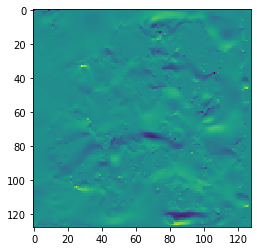

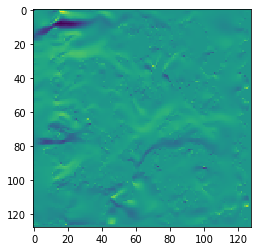

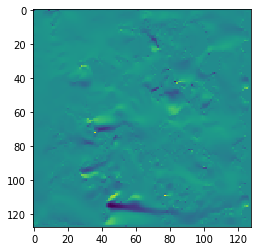

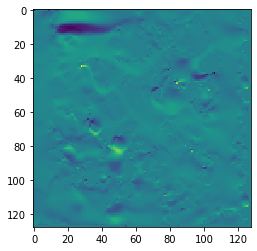

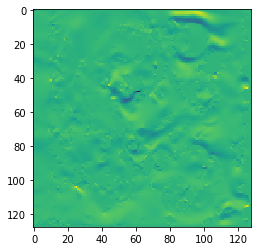

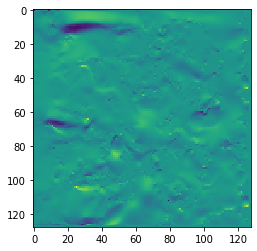

KeyboardInterrupt: 

In [ ]:
for b in B:
    plt.imshow(b)
    plt.show()

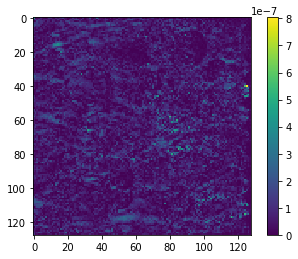

In [ ]:
plt.imshow(np.abs(B[0]-BB0))
plt.colorbar()
plt.show()

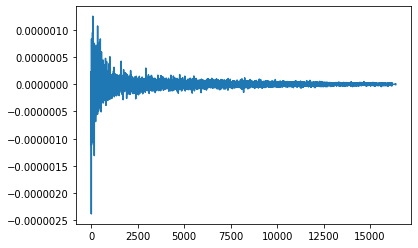

In [ ]:
t = np.arange(numComp)
plt.plot(t,cc-coeffs[0][0])

In [ ]:
C = X[0:simLen].reshape(simLen,gridsize,gridsize).numpy()
print(C.shape)

(500, 128, 128)


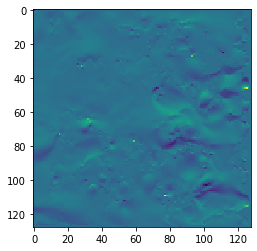

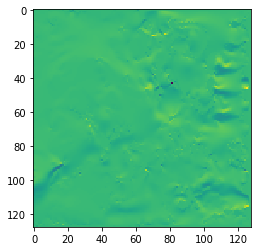

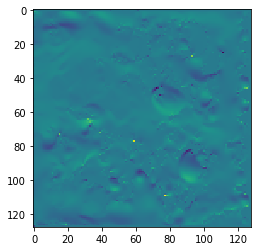

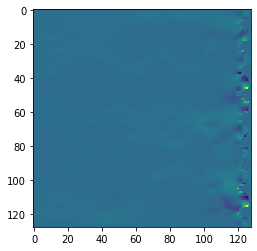

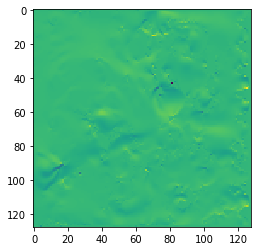

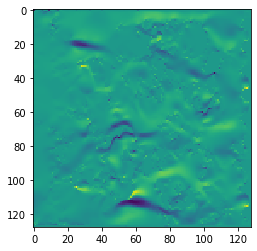

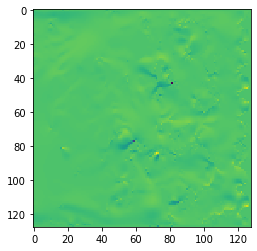

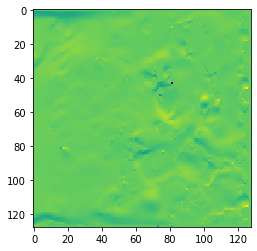

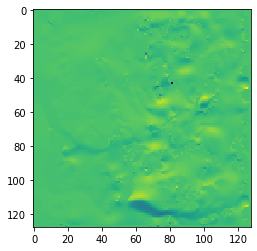

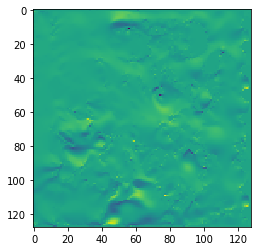

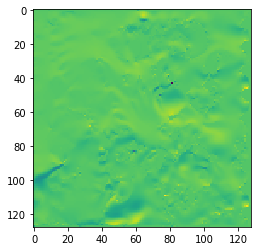

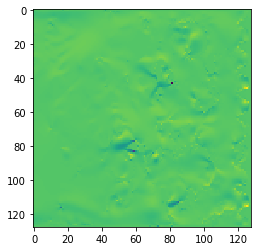

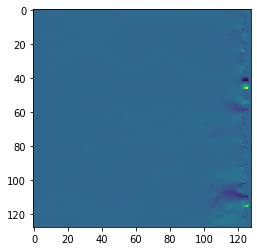

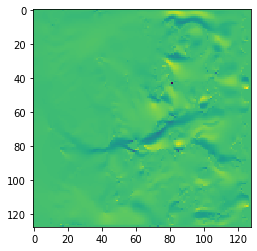

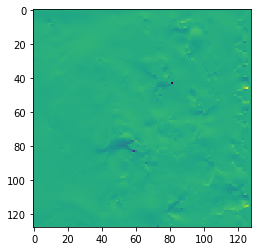

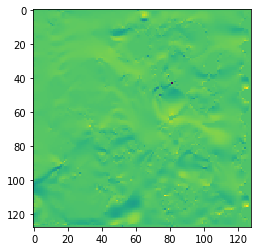

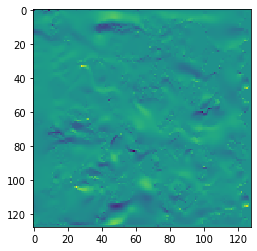

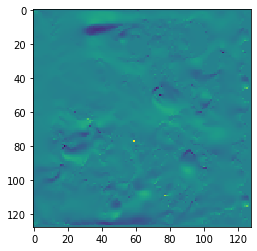

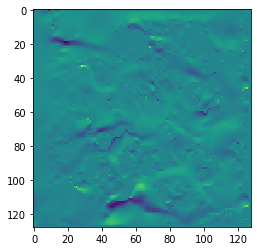

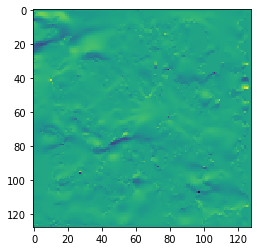

KeyboardInterrupt: 

In [ ]:
for c in C:
    plt.imshow(c)
    plt.show()

In [ ]:
re = rel_err(C,B)
re

5.8894705e-07

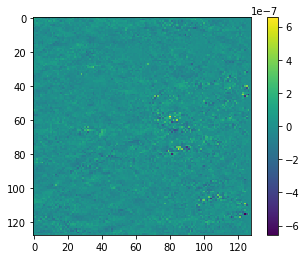

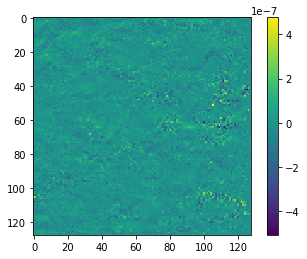

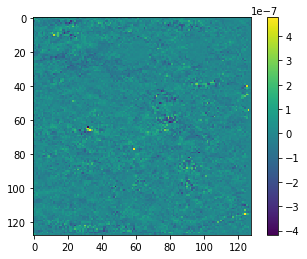

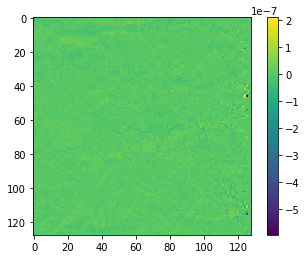

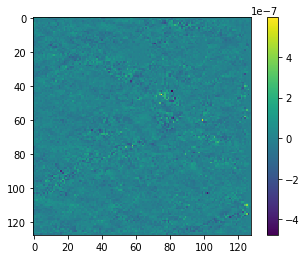

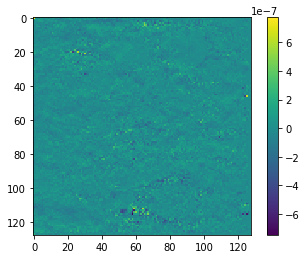

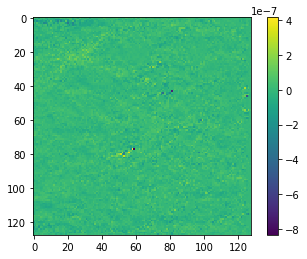

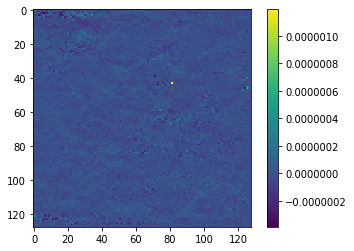

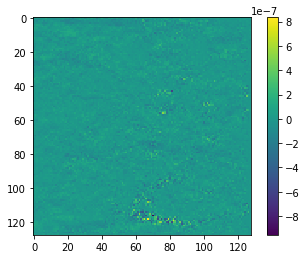

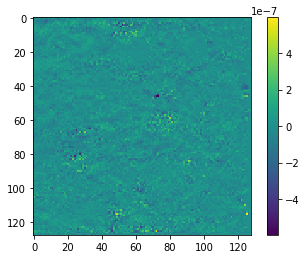

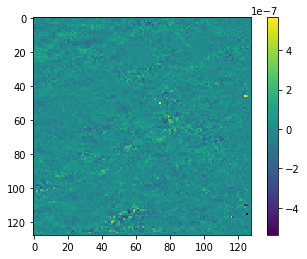

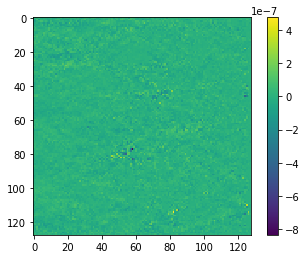

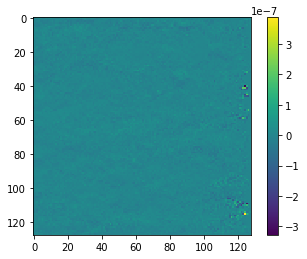

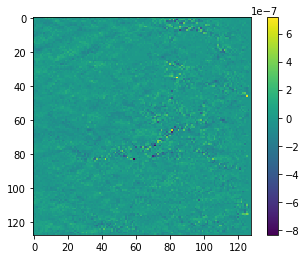

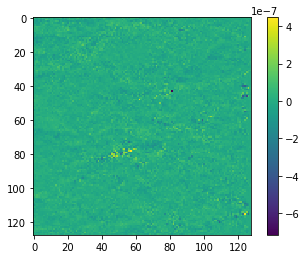

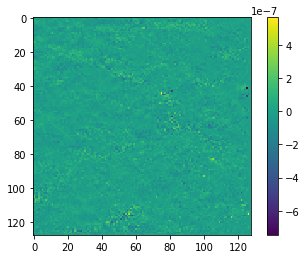

KeyboardInterrupt: 

In [ ]:
for b,c in zip(B,C):
    plt.imshow(c-b)
    plt.colorbar()
    plt.show()

In [ ]:
R = []
for b,c in zip(B,C):
    R.append(rel_err(c,b))


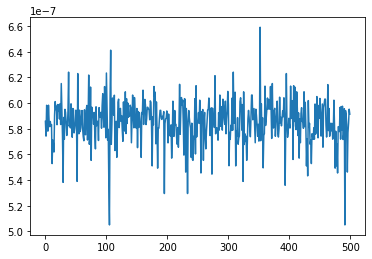

In [ ]:
plt.plot(R)

## Plot SVD Curves 

In [ ]:
latentDim = 0 
A = []
for c in coeffs:
    A.append(c[:,latentDim])
A = np.array(A).T
A.shape

(500, 50)

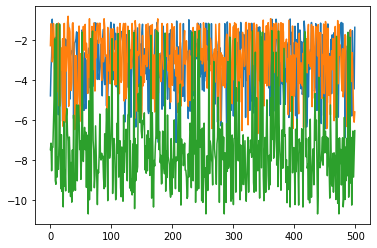

In [ ]:
plt.plot(A[:,:3])
plt.show()